# Accessing the ATLAS Open Data

This notebook is based on the use of  ATLAS Open Data 
http://opendata.atlas.cern

ATLAS Open Data provides open access to proton-proton collision data at the LHC. 

The ATLAS Collaboration makes avaliable approximately 1/10 of the data and the corresponding Monte Carlo samples for didactic purposes. 

The data are made available under the form of ROOT ntuples, the contents are:
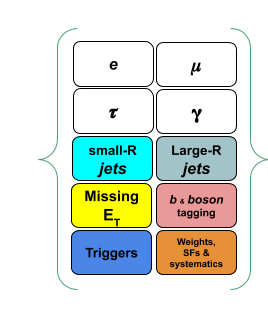

The meaning of these variables is explained in the lectures for the course.

Files for the 2-lepton final state were processed and saved into csv files, only including the four-vectors of
the reconstructed leptons, the two components of Etmiss and the number of jets, as well as a weight which allows the normalisation of the samples to an integrated luminosity of 10 fb-1

The csv files are loaded into pandas dataframes, and the aim of this logbook is to introduce the reader 
to the elementary manipulation of a pandas dataframe for a set of events produced by a multi-purpose 
HEP experiment such as the ones running at the LHC. 


## Installation of packages not available by default on colab

In [1]:
import sys
# update the pip package installer
#%pip install --upgrade --user pip
# install required packages
#%pip install --upgrade --user uproot awkward vector numpy matplotlib

#!pip install vector

## Import packages used in the analysis

We're going to be using a number of tools to help us:
* vector: to allow vectorized 4-momentum calculations
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [2]:
import vector # for 4-momentum calculations
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt
import pandas as pd

## File path

Files for processes including two leptons in the final state. We consider three files including the following simulated physics processes:

* pp -> WW -> llvv
* pp -> h -> WW -> llvv
* pp -> tt -> WWbb -> bbllvv

where "l" is an electron or a muon, "v" is a neutrino, escaping detection, and "b" is a jet produced from the hadronisation of a b-quark

The files are in csv format, and were processed from the ATLAS open data ntuples

In [3]:
#fn1="https://cernbox.cern.ch/remote.php/dav/public-files/6mTuRapglPXnwUT/hww_atlas.csv.gz" #hww
#fn1="https://cernbox.cern.ch/remote.php/dav/public-files/bt9p3KS952M0I11/ttlep_atlas.csv.gz" #ttlep
fn1="https://cernbox.cern.ch/remote.php/dav/public-files/ndKtAQHMxNUmumC/ww_atlas.csv.gz" #ww

# define the number of events one wants to read from csv files. For simple tests one may 
# want to define a small number of events to speed up processing
N = 10000
print("Size of dataset : %i"%N)
dftot = pd.read_csv(fn1, compression='gzip', header=0,nrows=N,engine='python')

Size of dataset : 600000


Inspect the created dataframe

In [4]:
coln=dftot.columns

print(coln)

print(dftot.shape)

print(dftot.head())

print(dftot.info())

Index(['ptl1', 'etal1', 'phil1', 'el1', 'chl1', 'typl1', 'ptl2', 'etal2',
       'phil2', 'el2', 'chl2', 'typl2', 'met_et', 'met_phi', 'jet_n',
       'totalWeight'],
      dtype='object')
(10000, 16)
           ptl1     etal1     phil1           el1  chl1  typl1          ptl2  \
0  66719.210938  0.302357  2.448181  69792.250000   1.0   11.0  38223.332031   
1  29149.914062  1.102973  1.423768  48753.128906  -1.0   11.0  29030.730469   
2  52254.113281 -0.618223  2.940946  62562.000000   1.0   11.0  43302.742188   
3  33380.015625  0.246225 -2.339833  34397.000000   1.0   11.0  29918.826172   
4  36902.187500  1.114667  0.709427  62301.644531  -1.0   13.0  31770.462891   

      etal2     phil2            el2  chl2  typl2      met_et   met_phi  \
0  1.466256 -2.912213   87221.343750  -1.0   13.0  130877.860  1.609380   
1 -0.051656  1.128289   29069.662109   1.0   13.0   36958.645 -1.323970   
2 -1.738426 -0.194456  126967.546875  -1.0   13.0   42118.477 -0.893646   
3  0.042298  1.883

# Manipulation of the contents of the dataframe

Having in memory a dataframe representing the features of the events we are interested in, we want to

* Create derivate variables fron the 4-vectors of the two leptons and insert them in the database
* Drop variables which may be redundant
* Apply selections on the variables to reduce the size of the dataframes

### Build 4-vectors for each of the two leptons

In order to perform operations on leptons to create high-level variables it is convenient to create 4-leptons objects on which dedicated libraries can perform kinematic calculations

It accesses the dataframe where the particle data are stored as scalar components, and creates an array of 4-vectors  based on the 'vector' library https://pypi.org/project/vector/

In [5]:
#
# create array of 4-vectors of two leptons and etmiss for calculation of derived
# variables
#
p4l1=vector.array({"pt":dftot["ptl1"], "phi":dftot["phil1"],
    "eta":dftot["etal1"], "e":dftot["el1"]})
p4l2=vector.array({"pt":dftot["ptl2"], "phi":dftot["phil2"],
    "eta":dftot["etal2"], "e":dftot["el2"]})
etmv=vector.array({"pt":dftot["met_et"], "phi":dftot["met_phi"]})

print(p4l1.size, p4l2.size, etmv.size)

10000 10000 10000


### Trivial check:
for first event and the first lepton show that the 'pt' variable of the 4-vector is indeed sqrt(px^2+py^2)

In [6]:
print("pt=",p4l1[0].pt)
print("px=",p4l1[0].px,"py=",p4l1[0].py)
ptrec=np.sqrt(p4l1.px**2+p4l1.py**2)
print("pt from components",ptrec[0])
theta=np.arctan(p4l1.pt/p4l1.pz)
print("theta rec",theta[0],"theta",p4l1[0].theta)

pt= 66719.2109375
px= -51311.73230835598 py= 42644.56865344327
pt from components 66719.2109375
theta rec 1.2729431816007153 theta 1.2729431816007153


 ## Add  higher level variables to ntuple
 
 Exploit the 4-vectors to build kinematic variables involving the two leptons
 most variables of interest can be easily built using the functions described in the page 
 https://pypi.org/project/vector/  (scroll a bit down to see what is available)

In [7]:
#
# replace azimuthal angle for two leptons with the azimutal distance from etmiss vector
#
dftot["dphil1m"]=p4l1.deltaphi(etmv)
dftot["dphil2m"]=p4l2.deltaphi(etmv)
dftot["ptsum"]=dftot["ptl1"]+dftot["ptl2"]

In [8]:
#  High level variables for 2-l+etm system
#
p4ll=p4l1+p4l2
ptll=p4ll.pt
dftot["ptll"]=ptll
#
#   if you want to save space
#   drop redundant variables
#
#df=dftot.drop(columns=['phil1','phil2','met_phi'])

df=dftot

coln=df.columns

print(coln)

print(df.head())

print(df.info())


Index(['ptl1', 'etal1', 'phil1', 'el1', 'chl1', 'typl1', 'ptl2', 'etal2',
       'phil2', 'el2', 'chl2', 'typl2', 'met_et', 'met_phi', 'jet_n',
       'totalWeight', 'dphil1m', 'dphil2m', 'ptsum', 'ptll'],
      dtype='object')
           ptl1     etal1     phil1           el1  chl1  typl1          ptl2  \
0  66719.210938  0.302357  2.448181  69792.250000   1.0   11.0  38223.332031   
1  29149.914062  1.102973  1.423768  48753.128906  -1.0   11.0  29030.730469   
2  52254.113281 -0.618223  2.940946  62562.000000   1.0   11.0  43302.742188   
3  33380.015625  0.246225 -2.339833  34397.000000   1.0   11.0  29918.826172   
4  36902.187500  1.114667  0.709427  62301.644531  -1.0   13.0  31770.462891   

      etal2     phil2            el2  chl2  typl2      met_et   met_phi  \
0  1.466256 -2.912213   87221.343750  -1.0   13.0  130877.860  1.609380   
1 -0.051656  1.128289   29069.662109   1.0   13.0   36958.645 -1.323970   
2 -1.738426 -0.194456  126967.546875  -1.0   13.0   42118.477 -0.8

Units, as stored in the data files. The quantities in the ATLAS ntuple are unfortunately stored in MeV.
Since the natural unit for LHC analysis is GeV, we define conversion factors

In [9]:
MeV = 0.001
GeV = 1.0

This is where the reading of the file happens

## Apply simple cuts to ntuple using query

First build the selection string, then apply it to the dataframe to create new dataframe with reduced number of events

In [10]:
# build the selection string
cutl1=50/MeV
cutl2=5/MeV
strcut="ptl1>"+str(cutl1)+" and ptl2>"+str(cutl2)
print(strcut)
# optionally, create smaller dataframe with only variables on which 
# selection is performed and variable one wants to plot
dfm4l=df.filter(items=['ptll','ptl1','ptl2'])
# create new dataframe after applying selection
dfm4l1=dfm4l.query(strcut)
# print efficiency of cut
print(" before ",dfm4l.shape[0]," after ",dfm4l1.shape[0], " efficiency ", dfm4l1.shape[0]/dfm4l.shape[0])

ptl1>50000.0 and ptl2>5000.0
 before  10000  after  6558  efficiency  0.6558


## Plotting

Set simple wrapper for plotting histograms with matplotlib

In [11]:
# in input:  df=dataframe var=variable in dataframe, 
# scale=scale factor on value of variable (e.g. for scaling between MeV and GeV)
# nbin,xlow,xhigh: limits of histogram
# norm: choose whether you plot acutal number of events in bin or fraction of events 
#       in each bin with respect to total
# labx, laby labels of x and y axis of histogram 
# title: title of hisotgram
# leg: legenda for content, useful if you superimpose two hists
def hist1d(df, var, scale, nbin, xlow, xhig, norm, labx, laby, title, leg):
  bins = np.linspace(xlow,xhig,nbin)
  plt.hist(df[var]*scale, bins, alpha=0.5, density=norm, label=leg)
  plt.xlabel(labx)
  plt.ylabel(laby)
  plt.legend(loc='best')
# 2d, same definition of inputs as above
def hist2d(df,var1,var2,scalex,scaley,nbinx,xlow,xhig,nbiny,ylow,yhig,labx,laby,title):
  binx = np.linspace(xlow,xhig,nbinx)
  biny = np.linspace(ylow,yhig,nbiny)
  plt.hist2d(df[var1]*scalex, df[var2]*scaley, bins=[binx, biny], density=False, cmin=0.5)
  plt.xlabel(labx)
  plt.ylabel(laby)

Call the functions to plot the data

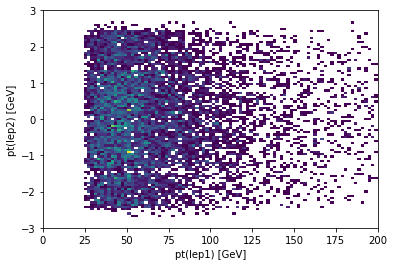

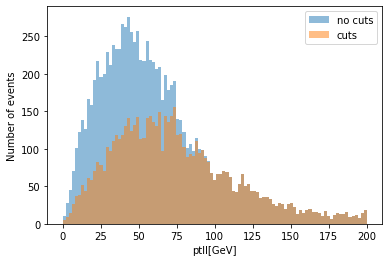

In [12]:
hist2d(df,"ptl1","etal1",MeV,1,100,0.,200.,100,-3.,3.,'pt(lep1) [GeV]','pt(lep2) [GeV]','')
plt.show()
hist1d(dfm4l,'ptll',MeV,100,0.,200,False,'ptll[GeV]','Number of events','','no cuts')
hist1d(dfm4l1,'ptll',MeV,100,0.,200,False,'ptll[GeV]','Number of events','','cuts')
plt.show()


<a id='going_further'></a>

## Exercises to familiarise yourself with data

The idea would be that you learn how to apply selection and add variables to a panda dataframe
and you understand the impact of the selections by calculating the efficiencies and histogramming 
the impact on other variables

You may want to perform the exercise below for different files, to see how the variables look
like for different samples. You can do that by commenting and uncommenting names of files
in the  <b>File path</b>  box

Alternatively you may want to create a separate dataframe for each of the input files 
and compare  how the distributions you extract from the exercises below look for different files

* Plot the distributions of the variables phil1 and phil2 and met_phi verify that they are flat
* Plot the distributions of the variables dphil1m and dphil2m 
* Select events where the two leptons are opposite charge-same flavour  
  (tip: chl1+chl2=0 and abs(typl1) = abs(typl2))
* Calculate efficiency 
* Add to the dataframe the azimuthal distance between the two leptons (dphill) using the vector library https://pypi.org/project/vector/ and plot it 
* Add to the dataframe the invariant mass of the two leptons (mll) using the vector library https://pypi.org/project/vector/ and plot it (hint: scroll down the page for the vector library to see which operations between pairs of vectors are available) 
* Plot the distribution of mll and dphill before and after the selection on lepton flavour/charge for the WW sample
* Redo it for the Higgs sample 